In [8]:
from giskardpy.python_interface.python_interface import GiskardWrapper
import rospy
from geometry_msgs.msg import PoseStamped, Point, Quaternion, Vector3Stamped, PointStamped, Vector3
from tf.transformations import quaternion_from_matrix, quaternion_about_axis
from giskardpy.goals.weight_scaling_goals import MaxManipulabilityLinWeight, BaseArmWeightScaling
from copy import deepcopy
from giskard_msgs.msg import WorldBody, CollisionEntry, WorldGoal, GiskardError
import numpy as np

In [15]:
rospy.init_node('giskard_examples')

In [18]:
# Launch the giskardpy PR2 standalone launch file before this
gs = GiskardWrapper()

In [5]:
def reset_giskard():
    gs.clear_motion_goals_and_monitors()
    gs.world.clear()
    default_pose = {
        'r_elbow_flex_joint': -0.15,
        'r_forearm_roll_joint': 0,
        'r_shoulder_lift_joint': 0,
        'r_shoulder_pan_joint': 0,
        'r_upper_arm_roll_joint': 0,
        'r_wrist_flex_joint': -0.10001,
        'r_wrist_roll_joint': 0,
        'l_elbow_flex_joint': -0.15,
        'l_forearm_roll_joint': 0,
        'l_shoulder_lift_joint': 0,
        'l_shoulder_pan_joint': 0,
        'l_upper_arm_roll_joint': 0,
        'l_wrist_flex_joint': -0.10001,
        'l_wrist_roll_joint': 0,
        'torso_lift_joint': 0.2,
        'head_pan_joint': 0,
        'head_tilt_joint': 0,
        'l_gripper_l_finger_joint': 0.55,
        'r_gripper_l_finger_joint': 0.55
    }
    done = gs.monitors.add_set_seed_configuration(default_pose)
    base_pose = PoseStamped()
    base_pose.header.frame_id = 'map'
    base_pose.pose.position = Point(0, 0, 0)
    base_pose.pose.orientation.w = 1
    done2 = gs.monitors.add_set_seed_odometry(base_pose=base_pose)
    gs.motion_goals.allow_all_collisions()
    gs.monitors.add_end_motion(start_condition=f'{done} and {done2}')
    gs.execute()
    gs.clear_motion_goals_and_monitors()


Giskard is a constraint- and optimization-based whole-body motion planning/control framework.
In short explain the QP...
Explain a constraint and how it influences the QP...
When using the python wrapper you do not specify constraints directly but rather a Motion Goal to parameterize a predefined set of constraints.
Additionally, the python interface allows to specify monitors that monitor a mathematical expression against a threshold and evaluate into a binary value.
They are used to start, stop or interrupt motion goals. More complex motion goals might specify their own monitors to chain constraints together.
Show picture of PR2 TF Tree...

The simplest possible motion goal call follows the following schema:

    - Define a motion goal.
    - Define a monitor that checks if the goal was reached.
    - Define an end motion monitor, which has as start_condition the goal reached monitor.


In [5]:
reset_giskard()

joint_goal = {'torso_lift_joint': 0.3}
joint_monitor = gs.monitors.add_joint_position(goal_state=joint_goal)
gs.motion_goals.add_joint_position(goal_state=joint_goal)
gs.monitors.add_end_motion(start_condition=joint_monitor)
assert gs.execute().error.code == GiskardError.SUCCESS

A commonly used goal is a cartesian pose goal. It is used to move a link of the robot to a specific pose. Frequently used links are the endeffector links or the base link.

In [7]:
reset_giskard()

# Define a goal pose in the map coordinate system
goal_pose = PoseStamped()
goal_pose.header.frame_id = 'map'
goal_pose.pose.orientation = Quaternion(*quaternion_from_matrix([[1, 0, 0, 0],
                                                                 [0, 1, 0, 0],
                                                                 [0, 0, 1, 0],
                                                                 [0, 0, 0, 1]]))
goal_pose.pose.position.x = 2.01
goal_pose.pose.position.y = -0.2
goal_pose.pose.position.z = 0.7
# specify the cartesian pose goal to move 'l_gripper_tool_frame' towards goal_pose by using the kinematic chain between 'l_gripper_tool_frame' and 'map'
gs.motion_goals.add_cartesian_pose(goal_pose, 'l_gripper_tool_frame', 'map')
# specify monitor that is active when it is below the given thresholds and use it to end the motion
pose_monitor = gs.monitors.add_cartesian_pose('map', 'l_gripper_tool_frame', goal_pose, position_threshold=0.01,
                                              orientation_threshold=0.01)
gs.monitors.add_end_motion(pose_monitor)
# in the case that there is no specific end motion condition the default end motion condition stops the motion when the robot stops moving i.e. the QP is in a local minimum.
# gs.add_default_end_motion_conditions()
assert gs.execute().error.code == GiskardError.SUCCESS

AssertionError: 

When adding an object to the world of giskard one can specify goal poses also in its coordinate frame. This is true for all links that are part of giskards world representation.

In [8]:
reset_giskard()

# adding a box to the world
box_pose = PoseStamped()
box_pose.header.frame_id = 'map'
box_pose.pose.orientation.w = 1
box_pose.pose.position.x = 2
box_pose.pose.position.y = -0.2
box_pose.pose.position.z = 0.7
gs.world.add_box('mybox', size=(0.1, 0.05, 0.2), pose=box_pose, parent_link='map')

# specfy a goal pose 8cm in front of the box origin frame
goal_pose = PoseStamped()
goal_pose.header.frame_id = 'mybox'
goal_pose.pose.orientation.w = 1
goal_pose.pose.position.x = -0.08
goal_pose.pose.position.y = 0
goal_pose.pose.position.z = 0
gs.motion_goals.add_cartesian_pose(goal_pose, 'l_gripper_tool_frame', 'map')
pose_monitor = gs.monitors.add_cartesian_pose('map', 'l_gripper_tool_frame', goal_pose, position_threshold=0.01,
                                              orientation_threshold=0.01)
gs.monitors.add_end_motion(pose_monitor)
assert gs.execute().error.code == GiskardError.SUCCESS

When using the cartesian goals all degrees of freedom of the link are fully constrained. One Advantage of constraint-based control is that one can only constrain neccessary constraints.
The unconstrained DOF can then be exploited during the motion, for example in the collision avoidance or other secondary tasks.
To use this in the python interface one can use motion goals that constrain only a singualar value, here also called constraints on feature functions.
For a feature function constraint a feature (Point or Vector) related to the robot and one related to the world has to be defined.
The name of the function then defines how they will be combined and 0 or 2 constraint values can be provided.
Right now we support the following feature functions:

    - Perpendicular(world_vector, robot_vector)
    - Height(world_point, robot_point, lower_limit, upper_limit)
    - Distance(world_point, robot_point, lower_limit, upper_limit)
    - Pointing(world_point, robot_vector)
    - Align(world_vector, robot_vector)
    - Angle(world_vector, robot_vector, lower_limit, upper_limit)

Robot features will be visualized as red points or arrows and world features have the color green.

In [11]:
reset_giskard()
# Define a world feature as a point at the origin of map
world_feature = PointStamped()
world_feature.header.frame_id = 'map'

# Define a robot feature as a point at the origin of the right gripper tool frame
robot_feature = PointStamped()
robot_feature.header.frame_id = 'r_gripper_tool_frame'

# use the distance feature function to constrain the distance between the features to be between 2m and 2.5m
gs.motion_goals.add_distance(root_link='map',
                             tip_link='r_gripper_tool_frame',
                             reference_point=world_feature,
                             tip_point=robot_feature,
                             lower_limit=2,
                             upper_limit=2.5)

gs.add_default_end_motion_conditions()
assert gs.execute().error.code == GiskardError.SUCCESS

Now for positioning the gripper to grasp a cylindrical object one can use three different feature function constraints

1. Pointing the gripper towards the object center
2. keeping a suitable distance
3. constrain the height to be within the dimensions of the objects

In [13]:
reset_giskard()

# variables
gripper_link = 'r_gripper_tool_frame'

# adding the object
cyl_pose = PoseStamped()
cyl_pose.header.frame_id = 'map'
cyl_pose.pose.orientation.w = 1
cyl_pose.pose.position = Point(2, -0.2, 1.2)
gs.world.add_cylinder('mycyl', height=0.2, radius=0.02, pose=cyl_pose, parent_link='map')

# define the robot features
robot_pointing_feature = Vector3Stamped()
robot_pointing_feature.header.frame_id = gripper_link
robot_pointing_feature.vector = Vector3(1, 0, 0)

robot_point_feature = PointStamped()
robot_point_feature.header.frame_id = gripper_link
robot_point_feature.point = Point(0, 0, 0)

# define the world features
world_cylinder_center_feature = PointStamped()
world_cylinder_center_feature.header.frame_id = 'mycyl'
world_cylinder_center_feature.point = Point(0, 0, 0)

# define the constraints
gs.motion_goals.add_distance(root_link='map',
                             tip_link=gripper_link,
                             reference_point=world_cylinder_center_feature,
                             tip_point=robot_point_feature,
                             lower_limit=0.03,
                             upper_limit=0.03)
gs.motion_goals.add_height(root_link='map',
                           tip_link=gripper_link,
                           reference_point=world_cylinder_center_feature,
                           tip_point=robot_point_feature,
                           lower_limit=-0.05,
                           upper_limit=0.05)
gs.motion_goals.add_pointing(root_link='map',
                             tip_link=gripper_link,
                             goal_point=world_cylinder_center_feature,
                             pointing_axis=robot_pointing_feature)
# EXCERCISE SOLUTION:
# robot_gripper_z_axis_feature = Vector3Stamped()
# robot_gripper_z_axis_feature.header.frame_id = gripper_link
# robot_gripper_z_axis_feature.vector = Vector3(0, 0, 1)
#
# world_cyl_z_axis_feature = Vector3Stamped()
# world_cyl_z_axis_feature.header.frame_id = 'mycyl'
# world_cyl_z_axis_feature.vector = Vector3(0, 0, 1)
#
# gs.motion_goals.add_align_planes(root_link='map',
#                                 tip_link=gripper_link,
#                                 goal_normal=world_cyl_z_axis_feature,
#                                 tip_normal=robot_gripper_z_axis_feature)

gs.add_default_end_motion_conditions()
assert gs.execute().error.code == GiskardError.SUCCESS

# EXERCISE:
# 1. Change the position of the cylinder and the constraint values, and observe the resulting grasp poses.
# 2. You might notice that not all poses are feasible. This is due to a missing that constraint that allows the gripper_frame to freely rotate around its x-axis. Try to constrain this using the AlignFeatureFunction

Another advantage of having unconstrained DOF in the motion specification can be seen if we put an obstacle in front of the object we want to grasp and configure the collision avoidance to avoid this obstacle with all parts of the robot.

In [14]:
reset_giskard()

# variables
gripper_link = 'r_gripper_tool_frame'

# adding the object
cyl_pose = PoseStamped()
cyl_pose.header.frame_id = 'map'
cyl_pose.pose.orientation.w = 1
cyl_pose.pose.position = Point(2, -0.2, 1.2)
gs.world.add_cylinder('mycyl', height=0.2, radius=0.02, pose=cyl_pose, parent_link='map')

obstacle_pose = PoseStamped()
obstacle_pose.header.frame_id = 'mycyl'
obstacle_pose.pose.orientation.w = 1
obstacle_pose.pose.position = Point(-0.1, 0.1, 0)
gs.world.add_box('obstacle', size=(0.02, 0.06, 0.05), pose=obstacle_pose, parent_link='mycyl')

# define the robot features
robot_pointing_feature = Vector3Stamped()
robot_pointing_feature.header.frame_id = gripper_link
robot_pointing_feature.vector = Vector3(1, 0, 0)

robot_point_feature = PointStamped()
robot_point_feature.header.frame_id = gripper_link
robot_point_feature.point = Point(0, 0, 0)

robot_gripper_z_axis_feature = Vector3Stamped()
robot_gripper_z_axis_feature.header.frame_id = gripper_link
robot_gripper_z_axis_feature.vector = Vector3(0, 0, 1)

# define the world features
world_cylinder_center_feature = PointStamped()
world_cylinder_center_feature.header.frame_id = 'mycyl'
world_cylinder_center_feature.point = Point(0, 0, 0)

world_cyl_z_axis_feature = Vector3Stamped()
world_cyl_z_axis_feature.header.frame_id = 'mycyl'
world_cyl_z_axis_feature.vector = Vector3(0, 0, 1)

# define the constraints
gs.motion_goals.add_distance(root_link='map',
                             tip_link=gripper_link,
                             reference_point=world_cylinder_center_feature,
                             tip_point=robot_point_feature,
                             lower_limit=0.03,
                             upper_limit=0.03)
gs.motion_goals.add_height(root_link='map',
                           tip_link=gripper_link,
                           reference_point=world_cylinder_center_feature,
                           tip_point=robot_point_feature,
                           lower_limit=-0.05,
                           upper_limit=0.05)
gs.motion_goals.add_pointing(root_link='map',
                             tip_link=gripper_link,
                             goal_point=world_cylinder_center_feature,
                             pointing_axis=robot_pointing_feature)
gs.motion_goals.avoid_collision(min_distance=0.1, group1='obstacle')
gs.motion_goals.add_align_planes(root_link='map',
                                 tip_link=gripper_link,
                                 goal_normal=world_cyl_z_axis_feature,
                                 tip_normal=robot_gripper_z_axis_feature)
gs.add_default_end_motion_conditions()
assert gs.execute().error.code == GiskardError.SUCCESS

# EXERCISE:
# 1. Change Pose and size of the obstacle and see of the robot behaves.

Now, for each constraint a related monitor can be added to observe their progression and collect feedback in the case of failure where one or many constraints cannot be satisfied.

In [10]:
reset_giskard()

# variables
gripper_link = 'r_gripper_tool_frame'

# adding the object
cyl_pose = PoseStamped()
cyl_pose.header.frame_id = 'map'
cyl_pose.pose.orientation.w = 1
cyl_pose.pose.position = Point(2, -0.2, 1.2)
gs.world.add_cylinder('mycyl', height=0.2, radius=0.02, pose=cyl_pose, parent_link='map')

obstacle_pose = PoseStamped()
obstacle_pose.header.frame_id = 'mycyl'
obstacle_pose.pose.orientation.w = 1
obstacle_pose.pose.position = Point(-0.1, 0.1, 0)
gs.world.add_box('obstacle', size=(0.02, 0.06, 0.05), pose=obstacle_pose, parent_link='mycyl')

# define the robot features
robot_pointing_feature = Vector3Stamped()
robot_pointing_feature.header.frame_id = gripper_link
robot_pointing_feature.vector = Vector3(1, 0, 0)

robot_point_feature = PointStamped()
robot_point_feature.header.frame_id = gripper_link
robot_point_feature.point = Point(0, 0, 0)

robot_gripper_z_axis_feature = Vector3Stamped()
robot_gripper_z_axis_feature.header.frame_id = gripper_link
robot_gripper_z_axis_feature.vector = Vector3(0, 0, 1)

# define the world features
world_cylinder_center_feature = PointStamped()
world_cylinder_center_feature.header.frame_id = 'mycyl'
world_cylinder_center_feature.point = Point(0, 0, 0)

world_cyl_z_axis_feature = Vector3Stamped()
world_cyl_z_axis_feature.header.frame_id = 'mycyl'
world_cyl_z_axis_feature.vector = Vector3(0, 0, 1)

# define the constraints
gs.motion_goals.add_distance(root_link='map',
                             tip_link=gripper_link,
                             reference_point=world_cylinder_center_feature,
                             tip_point=robot_point_feature,
                             lower_limit=0.0,
                             upper_limit=0.0)
mon_dist = gs.monitors.add_distance(root_link='map',
                                    tip_link=gripper_link,
                                    reference_point=world_cylinder_center_feature,
                                    tip_point=robot_point_feature,
                                    lower_limit=-0.001,
                                    upper_limit=0.001)

gs.motion_goals.add_height(root_link='map',
                           tip_link=gripper_link,
                           reference_point=world_cylinder_center_feature,
                           tip_point=robot_point_feature,
                           lower_limit=-0.05,
                           upper_limit=0.05)
mon_height = gs.monitors.add_height(root_link='map',
                                    tip_link=gripper_link,
                                    reference_point=world_cylinder_center_feature,
                                    tip_point=robot_point_feature,
                                    lower_limit=-0.05,
                                    upper_limit=0.05)

gs.motion_goals.add_pointing(root_link='map',
                             tip_link=gripper_link,
                             goal_point=world_cylinder_center_feature,
                             pointing_axis=robot_pointing_feature)
mon_pointing = gs.monitors.add_pointing_at(root_link='map',
                                           tip_link=gripper_link,
                                           goal_point=world_cylinder_center_feature,
                                           pointing_axis=robot_pointing_feature)

gs.motion_goals.add_align_planes(root_link='map',
                                 tip_link=gripper_link,
                                 goal_normal=world_cyl_z_axis_feature,
                                 tip_normal=robot_gripper_z_axis_feature)
mon_align = gs.monitors.add_vectors_aligned(root_link='map',
                                            tip_link=gripper_link,
                                            goal_normal=world_cyl_z_axis_feature,
                                            tip_normal=robot_gripper_z_axis_feature)

gs.motion_goals.allow_all_collisions()
gs.motion_goals.avoid_collision(min_distance=0.08, group1='obstacle')
gs.monitors.add_end_motion(f'{mon_dist} and {mon_height} and {mon_align} and {mon_pointing}')
gs.monitors.add_cancel_motion(gs.monitors.add_local_minimum_reached(),
                              error_message='local minimum reached while monitors are not satisfied')
result = gs.execute()
if result.error.code != GiskardError.SUCCESS:
    gs.get_end_motion_reason(show_all=False)
# EXERCISE:
# The output tells you which monitor of the end motion was not successful. Try changing/removing/adding constraint and monitors to realize a successful execution.

{'PointingAt': False, 'Sleep': False}

Combination of constraints and cost function augmentations to
- place both grippers at specific poses (2 6D Pose Constraints)
- keep the line of sight on the left gripper (Pointing Constraint)
- prefer using base movements if the grippers are further away from their goal poses and avoid base movements if they are close to their goals (Quadratic Weight Scaling)
- maximize the manipulability in each arm (Linear weight term in the cost function)

In [16]:
reset_giskard()

js = {
    # 'torso_lift_joint': 0.2999225173357618,
    'head_pan_joint': 0.041880780651479044,
    'head_tilt_joint': -0.37,
    'r_upper_arm_roll_joint': -0.9487714747527726,
    'r_shoulder_pan_joint': -1.0047307505973626,
    'r_shoulder_lift_joint': 0.48736790658811985,
    'r_forearm_roll_joint': -14.895833882874182,
    'r_elbow_flex_joint': -1.392377908925028,
    'r_wrist_flex_joint': -0.4548695149411013,
    'r_wrist_roll_joint': 0.11426798984097819,
    'l_upper_arm_roll_joint': 1.7383062350263658,
    'l_shoulder_pan_joint': 1.8799810286792007,
    'l_shoulder_lift_joint': 0.011627231224188975,
    'l_forearm_roll_joint': 312.67276414458695,
    'l_elbow_flex_joint': -2.0300928925694675,
    'l_wrist_flex_joint': -0.10014623223021513,
    'l_wrist_roll_joint': -6.062015047706399,
}
gs.motion_goals.add_joint_position(js)
gs.motion_goals.allow_all_collisions()
gs.add_default_end_motion_conditions()
gs.execute()

goal_pose = PoseStamped()
goal_pose.header.frame_id = 'map'
goal_pose.pose.orientation = Quaternion(*quaternion_from_matrix([[1, 0, 0, 0],
                                                                 [0, 1, 0, 0],
                                                                 [0, 0, 1, 0],
                                                                 [0, 0, 0, 1]]))
goal_pose.pose.position.x = 2.01
goal_pose.pose.position.y = -0.2
goal_pose.pose.position.z = 0.7

goal_pose2 = deepcopy(goal_pose)
goal_pose2.pose.position.y = -0.6
goal_pose2.pose.position.z = 0.8
goal_pose2.pose.orientation = Quaternion(*quaternion_from_matrix([[0, 0, 1, 0],
                                                                  [0, 1, 0, 0],
                                                                  [-1, 0, 0, 0],
                                                                  [0, 0, 0, 1]]))

gs.motion_goals.add_cartesian_pose(goal_pose, 'l_gripper_tool_frame', 'map')
gs.motion_goals.add_cartesian_pose(goal_pose2, 'r_gripper_tool_frame', 'map', name='cart2')

goal_point = PointStamped()
goal_point.header.frame_id = goal_pose.header.frame_id
goal_point.point = goal_pose.pose.position
pointing_axis = Vector3Stamped()
pointing_axis.header.frame_id = 'wide_stereo_optical_frame'
pointing_axis.vector.z = 1
gs.motion_goals.add_pointing(goal_point, 'wide_stereo_optical_frame', pointing_axis, 'map')

x_base = Vector3Stamped()
x_base.header.frame_id = 'base_link'
x_base.vector.x = 1
x_goal = Vector3Stamped()
x_goal.header.frame_id = 'map'
x_goal.vector.x = 1
gs.motion_goals.add_align_planes(tip_link='base_link',
                                 root_link='map',
                                 tip_normal=x_base,
                                 goal_normal=x_goal)

tip_goal = PointStamped()
tip_goal.header.frame_id = 'map'
tip_goal.point = goal_pose.pose.position
gs.motion_goals.add_motion_goal(motion_goal_class=BaseArmWeightScaling.__name__,
                                root_link='map',
                                tip_link='l_gripper_tool_frame',
                                tip_goal=tip_goal,
                                gain=100000,
                                arm_joints=[
                                    'torso_lift_joint',
                                    # 'head_pan_joint',
                                    # 'head_tilt_joint',
                                    'r_upper_arm_roll_joint',
                                    'r_shoulder_pan_joint',
                                    'r_shoulder_lift_joint',
                                    'r_forearm_roll_joint',
                                    'r_elbow_flex_joint',
                                    'r_wrist_flex_joint',
                                    'r_wrist_roll_joint',
                                    'l_upper_arm_roll_joint',
                                    'l_shoulder_pan_joint',
                                    'l_shoulder_lift_joint',
                                    'l_forearm_roll_joint',
                                    'l_elbow_flex_joint',
                                    'l_wrist_flex_joint',
                                    'l_wrist_roll_joint'],
                                base_joints=['brumbrum'])
gs.motion_goals.add_motion_goal(motion_goal_class=MaxManipulabilityLinWeight.__name__,
                                root_link='torso_lift_link',
                                tip_link='r_gripper_tool_frame')
gs.motion_goals.add_motion_goal(motion_goal_class=MaxManipulabilityLinWeight.__name__,
                                root_link='torso_lift_link',
                                tip_link='l_gripper_tool_frame',
                                name='MaxMal2')
gs.add_default_end_motion_conditions()
gs.motion_goals.allow_all_collisions()
assert gs.execute().error.code == GiskardError.SUCCESS

# EXERCISE:
# 1.Comment the BaseArmWeightScaling and MaxManipulabilityLinWeight Goals to observe the resulting motions when the cost function is not augmented.


KeyboardInterrupt



### Environment Manipulation
If an environment is modelled as articulated links in an URDF Giskard can load it and control the joint states of the environment when it is connected to links of the robot.

In [27]:
reset_giskard()

# load the kitchen environment
kitchen_pose = PoseStamped()
kitchen_pose.header.frame_id = 'map'
kitchen_pose.pose.orientation.w = 1
gs.world.add_urdf(name='iai_kitchen',
                  urdf=rospy.get_param('kitchen_description'),
                  pose=kitchen_pose)

# Define poses and groups
p = PoseStamped()
p.header.frame_id = 'map'
p.pose.orientation.w = 1
p.pose.position.x = 0.5
p.pose.position.y = 0.2

hand = 'r_gripper_tool_frame'

goal_angle = np.pi / 4
handle_frame_id = 'sink_area_dish_washer_door_handle'
handle_name = 'sink_area_dish_washer_door_handle'
gs.world.register_group('dishwasher', root_link_name='sink_area_dish_washer_main',
                        root_link_group_name='iai_kitchen')
gs.world.register_group('handle', root_link_name=handle_name,
                        root_link_group_name='iai_kitchen')

# grasp the dishwasher handle
bar_axis = Vector3Stamped()
bar_axis.header.frame_id = handle_frame_id
bar_axis.vector.y = 1

bar_center = PointStamped()
bar_center.header.frame_id = handle_frame_id

tip_grasp_axis = Vector3Stamped()
tip_grasp_axis.header.frame_id = hand
tip_grasp_axis.vector.z = 1

gs.motion_goals.add_grasp_bar(root_link='map',
                              tip_link=hand,
                              tip_grasp_axis=tip_grasp_axis,
                              bar_center=bar_center,
                              bar_axis=bar_axis,
                              bar_length=.3)

x_gripper = Vector3Stamped()
x_gripper.header.frame_id = hand
x_gripper.vector.x = 1

x_goal = Vector3Stamped()
x_goal.header.frame_id = handle_frame_id
x_goal.vector.x = -1
gs.motion_goals.add_align_planes(tip_link=hand,
                                 root_link='map',
                                 tip_normal=x_gripper,
                                 goal_normal=x_goal)
gs.add_default_end_motion_conditions()
gs.execute()

# open the dishwasher
gs.motion_goals.add_open_container(tip_link=hand,
                                   environment_link=handle_name,
                                   goal_joint_state=goal_angle)
gs.motion_goals.allow_all_collisions()
gs.add_default_end_motion_conditions()
gs.execute()

# close the dishwasher
gs.motion_goals.add_open_container(tip_link=hand,
                                   environment_link=handle_name,
                                   goal_joint_state=0)
gs.motion_goals.allow_all_collisions()
gs.add_default_end_motion_conditions()
assert gs.execute().error.code == GiskardError.SUCCESS

### Monitors and Giskard Task Graphs
Until now, we have seen different motion goals and monitors to observe the success of the specified Motion Goals, i.e. constraints.
Another way to specify a motion with giskard is to utilize monitors and the start-, to_hold- and end_condition's each motion goal and monitor offer.
Doing this a chain, or more specifically a graph (task graph in Giskard terms), of motion goals is build up.
The task graph will be executed as one continuous controller (no need to recompile a new one for each goal).
After execution a picture of the task graph and a Gant diagram visualizing the execution order of goals and monitors can be inspected.
Next we will see simple example to execute two cartesian poses after each other.

In [30]:
reset_giskard()

pose1 = PoseStamped()
pose1.header.frame_id = 'map'
pose1.pose.position.x = 1
pose1.pose.orientation.w = 1

pose2 = PoseStamped()
pose2.header.frame_id = 'base_footprint'
pose2.pose.position.y = 1
pose2.pose.orientation.w = 1

root_link = 'map'
tip_link = 'base_footprint'

monitor1 = gs.monitors.add_cartesian_pose(name='pose1',
                                          root_link=root_link,
                                          tip_link=tip_link,
                                          goal_pose=pose1)

monitor2 = gs.monitors.add_cartesian_pose(name='pose2',
                                          root_link=root_link,
                                          tip_link=tip_link,
                                          goal_pose=pose2,
                                          absolute=True,
                                          start_condition=monitor1)
end_monitor = gs.monitors.add_local_minimum_reached()

gs.motion_goals.add_cartesian_pose(goal_pose=pose1,
                                   name='g1',
                                   root_link=root_link,
                                   tip_link=tip_link,
                                   end_condition=monitor1)
gs.motion_goals.add_cartesian_pose(goal_pose=pose2,
                                   name='g2',
                                   root_link=root_link,
                                   tip_link=tip_link,
                                   absolute=True,
                                   start_condition=monitor1,
                                   end_condition=f'{monitor2} and {end_monitor}')
gs.motion_goals.allow_all_collisions()
gs.monitors.add_end_motion(start_condition=' and '.join([end_monitor, monitor2]))
assert gs.execute().error.code == GiskardError.SUCCESS

**Visualize the Task Graph**

../tmp/task_graphs/goal_33.png


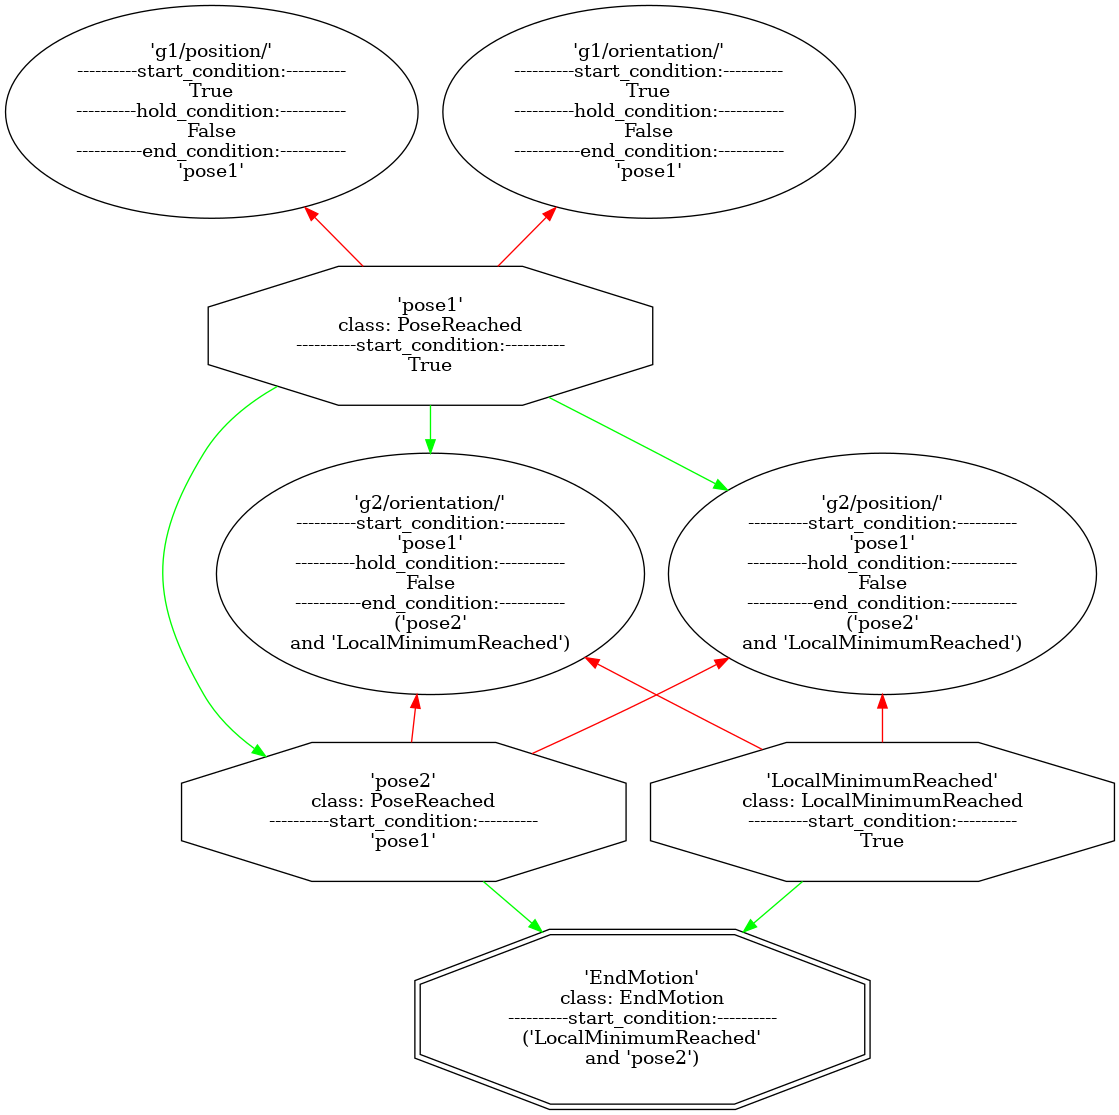

In [42]:
from IPython.display import Image, display
import os
import glob

folder_path = '../tmp/task_graphs'
files = glob.glob((os.path.join(folder_path, '*')))
latest_file = max(files, key=os.path.getmtime)
print(latest_file)
display(Image(filename=latest_file))

**Visualize the Gant diagramm**

../tmp/gantt_charts/goal_33.pdf


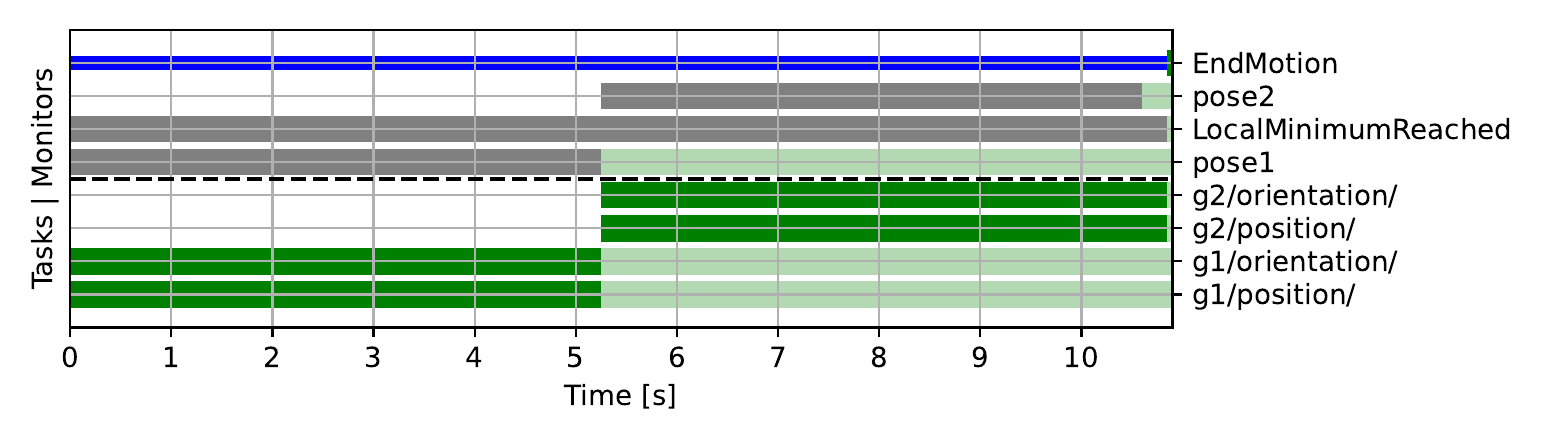

In [41]:
from IPython.display import display
from pdf2image import convert_from_path
import os
import glob

folder_path = '../tmp/gantt_charts'
files = glob.glob((os.path.join(folder_path, '*')))
latest_file = max(files, key=os.path.getmtime)
images = convert_from_path(latest_file)
print(latest_file)
display(images[0])

This can be utilized for arbitrary complex goals.